## Imports

In [7]:
import os, re, sys
from pathlib import Path
from typing import Tuple

import pandas as pd
from tqdm import tqdm

# Primary language detector
from langdetect import detect_langs, DetectorFactory
DetectorFactory.seed = 0

import langid

## Configuration

In [10]:
BASE_DIR = r"G:\MSc in Business Analystics\First Year\Semester 3\CMM724 - Web Mining\Coursework\Film Review\Review"

# Minimum confidence to keep a review as English
EN_THRESHOLD = 0.80

# Where to save processed outputs
SAVE_DIR = Path(BASE_DIR).parent / "processed"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

RAW_CSV = SAVE_DIR / "reviews_raw_with_lang.csv"
EN_CSV  = SAVE_DIR / "reviews_english_only.csv"

## Data Importing (Read .txt files from pos/neg)

In [13]:
def read_text_safe(fp: Path) -> str:
    for enc in ("utf-8", "latin-1"):
        try:
            with open(fp, "r", encoding=enc, errors="ignore") as f:
                txt = f.read()
            break
        except Exception:
            continue
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

def load_reviews(base_dir: str) -> pd.DataFrame:
    rows = []
    base = Path(base_dir)
    for label in ("neg", "pos"):
        folder = base / label
        if not folder.exists():
            print(f"WARNING: folder not found: {folder}")
            continue
        for fp in folder.glob("*.txt"):
            rows.append({
                "doc_id": fp.stem,
                "path": str(fp),
                "label": label,
                "text": read_text_safe(fp)
            })
    return pd.DataFrame(rows)

## Language Detection

In [16]:
def detect_language(text: str) -> Tuple[str, float, str]:
    text = (text or "").strip()
    if not text or len(text) < 10:
        # Too short for reliable detection
        return ("unknown", 0.0, "short")

    # 1) langdetect
    try:
        preds = detect_langs(text)
        top = preds[0]
        return (top.lang, float(top.prob), "langdetect")
    except Exception:
        pass

    # 2) langid backup
    try:
        lang, score = langid.classify(text)
        prob = 1.0 / (1.0 + pow(2.71828, -score))
        return (lang, float(prob), "langid")
    except Exception:
        return ("unknown", 0.0, "error")

## Pipeline Orchestration

In [19]:
def run_q3_1():
    # Load all reviews
    df = load_reviews(BASE_DIR)
    if df.empty:
        print("No files found. Please verify BASE_DIR.")
        sys.exit(1)

    # Detect language for each review
    langs, probs, sources = [], [], []
    for txt in tqdm(df["text"], desc="Detecting language"):
        lang, prob, src = detect_language(txt)
        langs.append(lang); probs.append(prob); sources.append(src)

    df["lang"] = langs
    df["lang_prob"] = probs
    df["lang_src"] = sources

    # Save raw
    df.to_csv(RAW_CSV, index=False, encoding="utf-8")
    print(f"\nSaved raw with language predictions:\n  {RAW_CSV}")

    # Filter English‑only
    df_en = df[(df["lang"] == "en") & (df["lang_prob"] >= EN_THRESHOLD)].copy()
    df_en.to_csv(EN_CSV, index=False, encoding="utf-8")
    print(f"Saved English‑only reviews:\n  {EN_CSV}")

    # Console summary
    print("\n========== Q3.1 SUMMARY ==========")
    total = len(df)
    total_en = len(df_en)
    print(f"Total reviews:        {total}")
    print(f"English‑only kept:    {total_en} ({(total_en/total)*100:.1f}%)\n")

    print("By class (raw):")
    print(df.groupby("label").size())

    print("\nBy class (English):")
    print(df_en.groupby("label").size())

    print("\nTop detected languages (raw):")
    print(df["lang"].value_counts().head(10))

    print("\nSample English rows:")
    with pd.option_context("display.max_colwidth", 100):
        print(df_en[["doc_id", "label", "lang", "lang_prob"]].head(10))

In [21]:
if __name__ == "__main__":
    run_q3_1()

Detecting language: 100%|██████████████████████████████████████████████████████████| 2000/2000 [00:24<00:00, 80.08it/s]



Saved raw with language predictions:
  G:\MSc in Business Analystics\First Year\Semester 3\CMM724 - Web Mining\Coursework\Film Review\processed\reviews_raw_with_lang.csv
Saved English‑only reviews:
  G:\MSc in Business Analystics\First Year\Semester 3\CMM724 - Web Mining\Coursework\Film Review\processed\reviews_english_only.csv

========== Q3.1 SUMMARY ==========
Total reviews:        2000
English‑only kept:    2000 (100.0%)

By class (raw):
label
neg    1000
pos    1000
dtype: int64

By class (English):
label
neg    1000
pos    1000
dtype: int64

Top detected languages (raw):
lang
en    2000
Name: count, dtype: int64

Sample English rows:
        doc_id label lang  lang_prob
0  cv000_29416   neg   en   0.999997
1  cv001_19502   neg   en   0.999997
2  cv002_17424   neg   en   0.999997
3  cv003_12683   neg   en   0.999997
4  cv004_12641   neg   en   0.999997
5  cv005_29357   neg   en   0.999995
6  cv006_17022   neg   en   0.999997
7   cv007_4992   neg   en   0.999997
8  cv008_29326   n

## Imports & Reproducibility

In [44]:
import os, re
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from tqdm import tqdm

RANDOM_STATE = 42

## Configuration (Paths & Outputs)

In [46]:
BASE_REVIEW_DIR = r"G:\MSc in Business Analystics\First Year\Semester 3\CMM724 - Web Mining\Coursework\Film Review\Review"

ENGLISH_CSV = str(Path(BASE_REVIEW_DIR).parent / "processed" / "reviews_english_only.csv")

FIG_DIR = Path(BASE_REVIEW_DIR).parent / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

WORDCLOUD_POS_PNG = FIG_DIR / "wordcloud_positive.png"
WORDCLOUD_NEG_PNG = FIG_DIR / "wordcloud_negative.png"

CUSTOM_STOPWORDS = {
    "film","movie","movies","one","two","also","even","really","would",
    "could","like","though","much","many","well","get","see","still"
}
STOPWORDS = ENGLISH_STOP_WORDS.union(CUSTOM_STOPWORDS)

## Load data

In [50]:
def read_text_safe(fp: Path) -> str:
    for enc in ("utf-8","latin-1"):
        try:
            return Path(fp).read_text(encoding=enc, errors="ignore")
        except Exception:
            continue
    return ""

def load_from_folders(base_dir: str) -> pd.DataFrame:
    base = Path(base_dir)
    rows = []
    for label in ("neg","pos"):
        folder = base / label
        for fp in folder.glob("*.txt"):
            rows.append({
                "doc_id": fp.stem,
                "label": label,
                "text": read_text_safe(fp)
            })
    return pd.DataFrame(rows)

def load_reviews() -> pd.DataFrame:
    en_csv = Path(ENGLISH_CSV)
    if en_csv.exists():
        print(f"Loading English-only CSV: {en_csv}")
        df = pd.read_csv(en_csv)
        needed = {"doc_id","label","text"}
        if not needed.issubset(df.columns):
            df = df[[c for c in df.columns if c in needed]]
        return df
    else:
        print(f"English CSV not found, reading raw folders from: {BASE_REVIEW_DIR}")
        return load_from_folders(BASE_REVIEW_DIR)

df = load_reviews()
print(df.head(3))
print(df["label"].value_counts())

Loading English-only CSV: G:\MSc in Business Analystics\First Year\Semester 3\CMM724 - Web Mining\Coursework\Film Review\processed\reviews_english_only.csv
        doc_id                                               path label  \
0  cv000_29416  G:\MSc in Business Analystics\First Year\Semes...   neg   
1  cv001_19502  G:\MSc in Business Analystics\First Year\Semes...   neg   
2  cv002_17424  G:\MSc in Business Analystics\First Year\Semes...   neg   

                                                text lang  lang_prob  \
0  plot : two teen couples go to a church party ,...   en   0.999997   
1  the happy bastard's quick movie review damn th...   en   0.999997   
2  it is movies like these that make a jaded movi...   en   0.999997   

     lang_src  
0  langdetect  
1  langdetect  
2  langdetect  
label
neg    1000
pos    1000
Name: count, dtype: int64


## Light cleaning & tokenization

In [53]:
TOKEN_RE = re.compile(r"\b[a-zA-Z][a-zA-Z'-]{1,}\b")

def clean_and_tokenize(text: str):
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)
    tokens = TOKEN_RE.findall(text)
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 2]
    return tokens

## Build class-specific corpora & frequencies

In [56]:
def collect_tokens_by_label(df: pd.DataFrame, label_value: str):
    all_tokens = []
    for txt in tqdm(df[df["label"] == label_value]["text"], desc=f"Tokenizing {label_value}"):
        all_tokens.extend(clean_and_tokenize(txt))
    return all_tokens

neg_tokens = collect_tokens_by_label(df, "neg")
pos_tokens = collect_tokens_by_label(df, "pos")

neg_freq = Counter(neg_tokens)
pos_freq = Counter(pos_tokens)


print("\nTop 20 NEGATIVE tokens:")
print(pd.DataFrame(neg_freq.most_common(20), columns=["token","count"]))

print("\nTop 20 POSITIVE tokens:")
print(pd.DataFrame(pos_freq.most_common(20), columns=["token","count"]))

Tokenizing pos: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2644.50it/s]



Top 20 NEGATIVE tokens:
         token  count
0         it's   1815
1         just   1561
2         good   1129
3         time   1112
4          bad   1019
5        story    905
6    character    893
7         plot    876
8   characters    872
9         make    818
10         way    753
11      little    721
12        does    702
13     doesn't    670
14       don't    663
15       scene    658
16      people    651
17       films    645
18        know    638
19      scenes    630

Top 20 POSITIVE tokens:
         token  count
0         it's   1888
1         just   1339
2        story   1215
3         good   1193
4         time   1171
5    character   1013
6   characters    984
7         life    982
8          way    915
9        films    879
10        does    865
11        best    810
12        make    772
13      little    769
14      people    768
15       great    744
16         new    719
17       scene    715
18         man    699
19        love    646


## Generate & save word clouds

Saved: G:\MSc in Business Analystics\First Year\Semester 3\CMM724 - Web Mining\Coursework\Film Review\reports\figures\wordcloud_negative.png


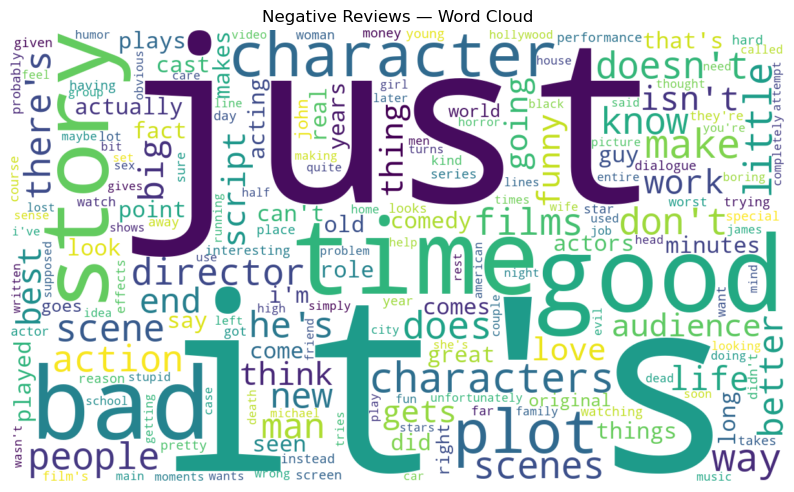

Saved: G:\MSc in Business Analystics\First Year\Semester 3\CMM724 - Web Mining\Coursework\Film Review\reports\figures\wordcloud_positive.png


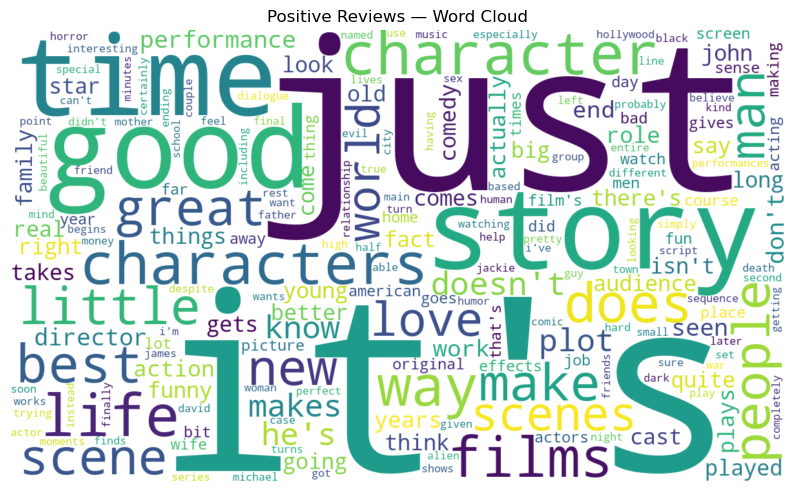

In [59]:
from wordcloud import WordCloud

def freq_to_wordcloud(freqs: Counter, title: str, out_path: Path):
    wc = WordCloud(
        width=1200,
        height=700,
        background_color="white",
        stopwords=STOPWORDS,
        collocations=False,
        random_state=RANDOM_STATE
    ).generate_from_frequencies(freqs)

    wc.to_file(str(out_path))
    print(f"Saved: {out_path}")

    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

def top_k(counter: Counter, k=5000) -> Counter:
    return Counter(dict(counter.most_common(k)))

freq_to_wordcloud(top_k(neg_freq, 5000), "Negative Reviews — Word Cloud", WORDCLOUD_NEG_PNG)
freq_to_wordcloud(top_k(pos_freq, 5000), "Positive Reviews — Word Cloud", WORDCLOUD_POS_PNG)

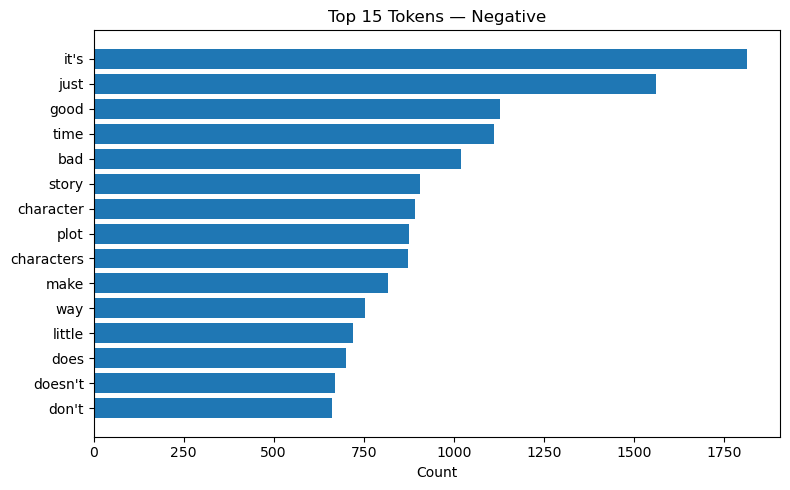

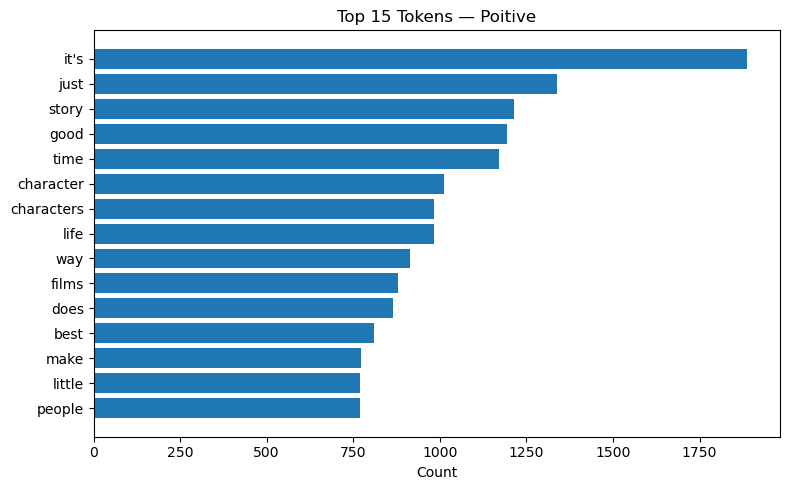

In [62]:
# --- [Optional: Top-15 bar charts] ---
def plot_top_n(counter: Counter, title: str, n=15):
    items = counter.most_common(n)
    tokens = [w for w,_ in items][::-1]
    counts = [c for _,c in items][::-1]

    plt.figure(figsize=(8,5))
    plt.barh(tokens, counts)   # (No explicit colors as per guideline)
    plt.title(title)
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

plot_top_n(neg_freq, "Top 15 Tokens — Negative", n=15)
plot_top_n(pos_freq, "Top 15 Tokens — Poitive", n=15)


## Imports

In [72]:
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
try:
    CUSTOM_STOPWORDS
except NameError:
    CUSTOM_STOPWORDS = set()

RANDOM_STATE = globals().get("RANDOM_STATE", 42)

## Extra stopwords for visuals only + contraction expansion

In [75]:
LIGHT_DOMAIN = {"film","films","movie","movies","scene","scenes"}
NEGATION_KEEP = {"not","no","nor","never"}

MODEL_STOPWORDS = (ENGLISH_STOP_WORDS | LIGHT_DOMAIN) - NEGATION_KEEP

VIZ_ONLY = {
    "it's","i'm","you're","we're","they're","does","did","made","makes",
    "doesn't","don't","isn't","wasn't","aren't","weren't","didn't","won't",
    "can't","couldn't","shouldn't","character","characters","story","plot","director",
    "just","time","way","people","life","make","makes","little","thing","things","lot"
}
VIZ_STOPWORDS = MODEL_STOPWORDS | VIZ_ONLY | CUSTOM_STOPWORDS

CONTRACTIONS = {
    "can't":"can not","won't":"will not","don't":"do not","doesn't":"does not","didn't":"did not",
    "isn't":"is not","wasn't":"was not","aren't":"are not","weren't":"were not",
    "shouldn't":"should not","couldn't":"could not","wouldn't":"would not",
    "haven't":"have not","hasn't":"has not","hadn't":"had not",
    "i'm":"i am","it's":"it is","that's":"that is","there's":"there is","what's":"what is","who's":"who is",
    "you're":"you are","we're":"we are","they're":"they are",
    "i've":"i have","we've":"we have","you've":"you have","they've":"they have",
    "i'd":"i would","you'd":"you would","he'd":"he would","she'd":"she would","we'd":"we would","they'd":"they would",
    "i'll":"i will","you'll":"you will","he'll":"he will","she'll":"she will","we'll":"we will","they'll":"they will"
}
CONTRACTION_RE = re.compile(r"\b(" + "|".join(map(re.escape, CONTRACTIONS.keys())) + r")\b")
def expand_contractions(text: str) -> str:
    text = text.lower()
    return CONTRACTION_RE.sub(lambda m: CONTRACTIONS[m.group(0)], text)

## Tokenization: lemmatize + negation scope

In [78]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet", quiet=True); nltk.download("omw-1.4", quiet=True)

TOKEN_RE = re.compile(r"\b[a-zA-Z][a-zA-Z'-]{1,}\b")
lemmatizer = WordNetLemmatizer()

def basic_tokens(text: str):
    text = expand_contractions(text)
    tokens = TOKEN_RE.findall(text)
    tokens = [t for t in tokens if len(t) > 2]
    # lemmatize (verb first, then noun) to merge variants
    tokens = [lemmatizer.lemmatize(t, pos="v") for t in tokens]
    tokens = [lemmatizer.lemmatize(t, pos="n") for t in tokens]
    return tokens

def apply_negation_scope(tokens, window=2):
    """Tag next `window` tokens after a negator with _NEG (for modeling only)."""
    negators = {"not","no","never"}
    tagged = []
    i = 0
    while i < len(tokens):
        tok = tokens[i]
        tagged.append(tok)
        if tok in negators:
            for j in range(1, window+1):
                if i + j < len(tokens):
                    tagged.append(tokens[i+j] + "_NEG")
            i += window + 1
        else:
            i += 1
    return tagged

def tokenize_for_visuals(text: str):
    toks = basic_tokens(text)
    return [t for t in toks if t not in VIZ_STOPWORDS]

def tokenize_for_model(text: str):
    toks = basic_tokens(text)
    toks = [t for t in toks if t not in MODEL_STOPWORDS]
    toks = apply_negation_scope(toks, window=2)
    return toks

## Rebuild cleaner clouds

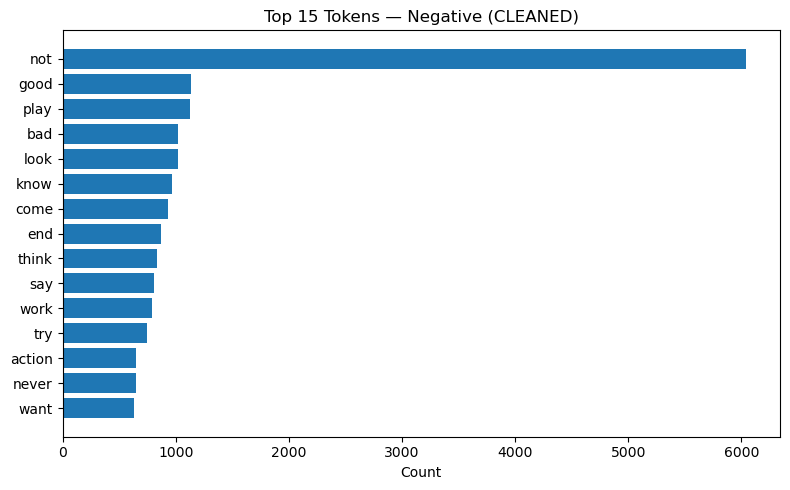

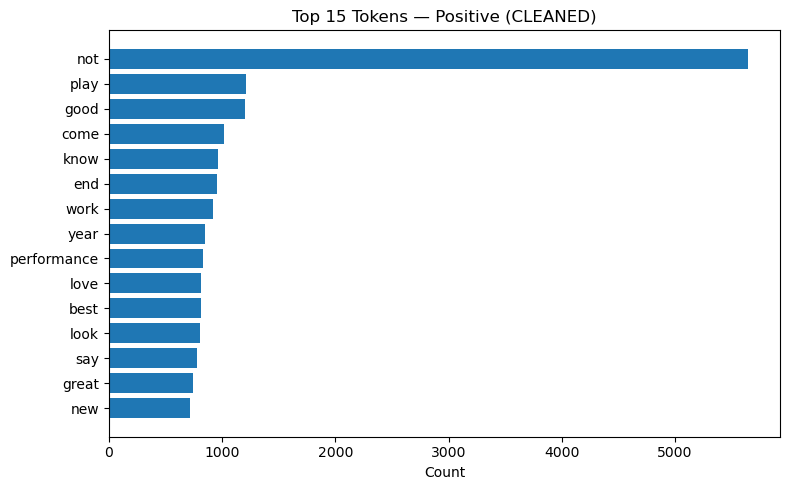

Saved: G:\MSc in Business Analystics\First Year\Semester 3\CMM724 - Web Mining\Coursework\Film Review\reports\figures\wordcloud_negative_clean.png


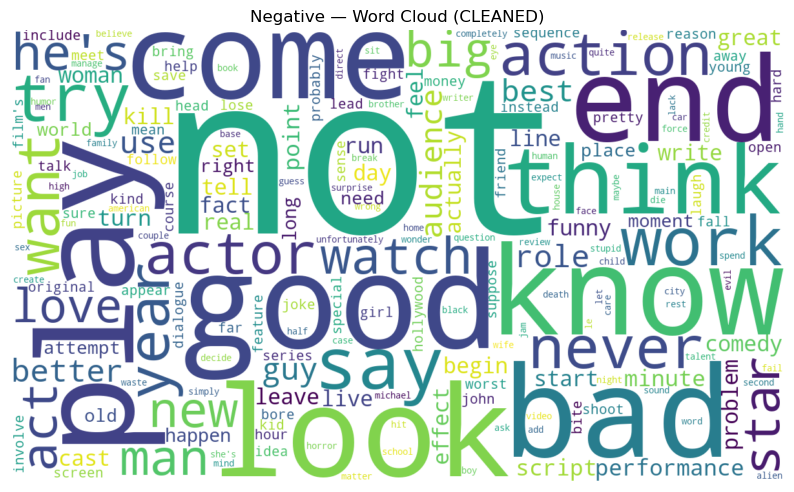

Saved: G:\MSc in Business Analystics\First Year\Semester 3\CMM724 - Web Mining\Coursework\Film Review\reports\figures\wordcloud_positive_clean.png


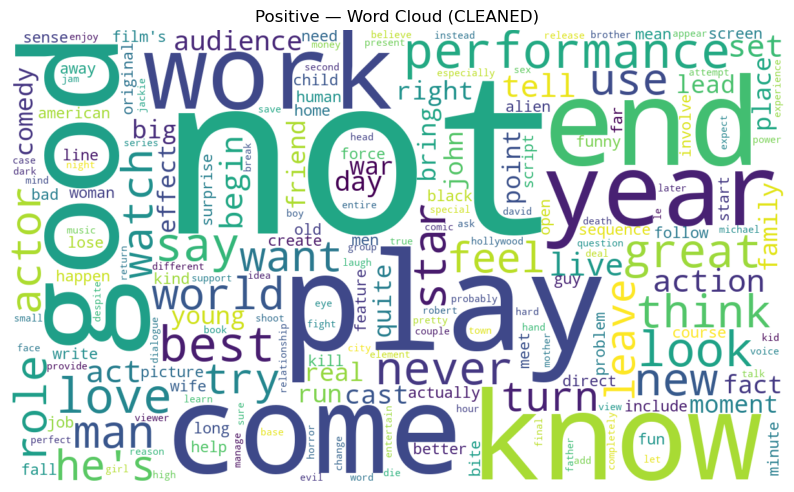

In [87]:
def collect_tokens_by_label(df, label_value, visual=True):
    out = []
    tok_fn = tokenize_for_visuals if visual else tokenize_for_model
    for txt in df[df["label"] == label_value]["text"]:
        out.extend(tok_fn(txt))
    return Counter(out)

neg_freq_clean = collect_tokens_by_label(df, "neg", visual=True)
pos_freq_clean = collect_tokens_by_label(df, "pos", visual=True)

def plot_top_n(counter, title: str, n=15):
    items = counter.most_common(n)
    tokens = [w for w,_ in items][::-1]
    counts = [c for _,c in items][::-1]
    plt.figure(figsize=(8,5))
    plt.barh(tokens, counts)
    plt.title(title); plt.xlabel("Count")
    plt.tight_layout(); plt.show()

plot_top_n(neg_freq_clean, "Top 15 Tokens — Negative (CLEANED)", 15)
plot_top_n(pos_freq_clean, "Top 15 Tokens — Positive (CLEANED)", 15)

WORDCLOUD_NEG_CLEAN = FIG_DIR / "wordcloud_negative_clean.png"
WORDCLOUD_POS_CLEAN = FIG_DIR / "wordcloud_positive_clean.png"

def save_wc(freqs, title, out_path):
    wc = WordCloud(
        width=1200, height=700, background_color="white",
        stopwords=VIZ_STOPWORDS, collocations=False, random_state=RANDOM_STATE
    ).generate_from_frequencies(freqs)
    wc.to_file(str(out_path))
    print(f"Saved: {out_path}")
    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation="bilinear"); plt.axis("off"); plt.title(title)
    plt.show()

save_wc(neg_freq_clean, "Negative — Word Cloud (CLEANED)", WORDCLOUD_NEG_CLEAN)
save_wc(pos_freq_clean, "Positive — Word Cloud (CLEANED)", WORDCLOUD_POS_CLEAN)

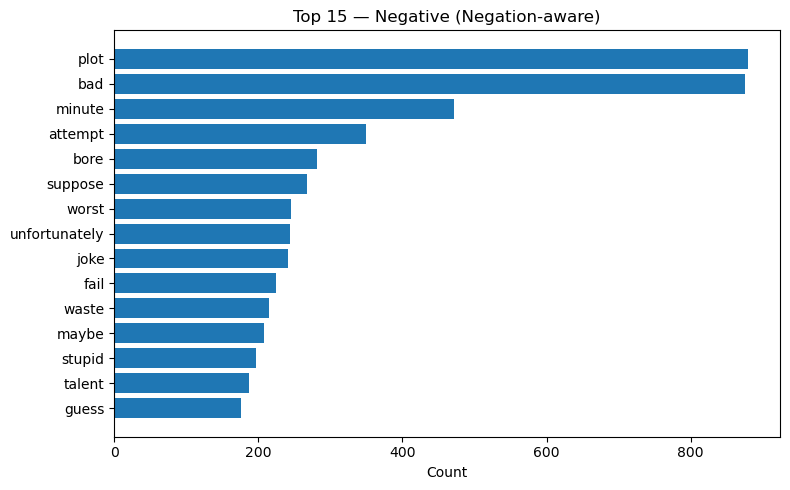

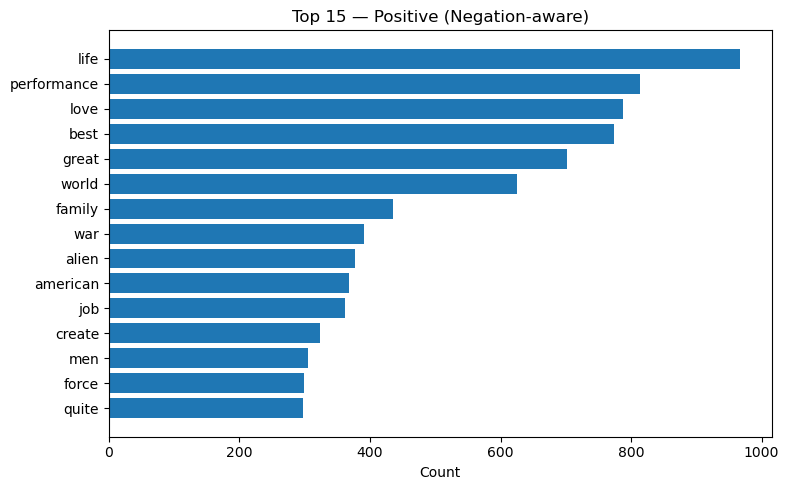

Saved: G:\MSc in Business Analystics\First Year\Semester 3\CMM724 - Web Mining\Coursework\Film Review\reports\figures\wordcloud_negative_negationaware.png


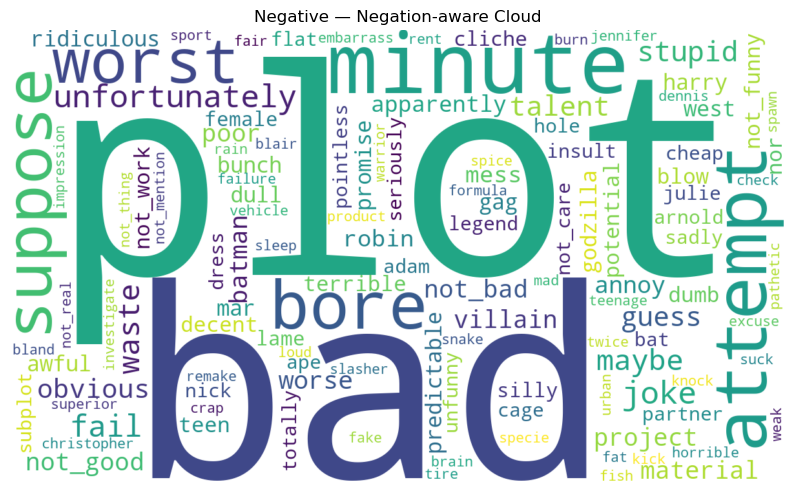

Saved: G:\MSc in Business Analystics\First Year\Semester 3\CMM724 - Web Mining\Coursework\Film Review\reports\figures\wordcloud_positive_negationaware.png


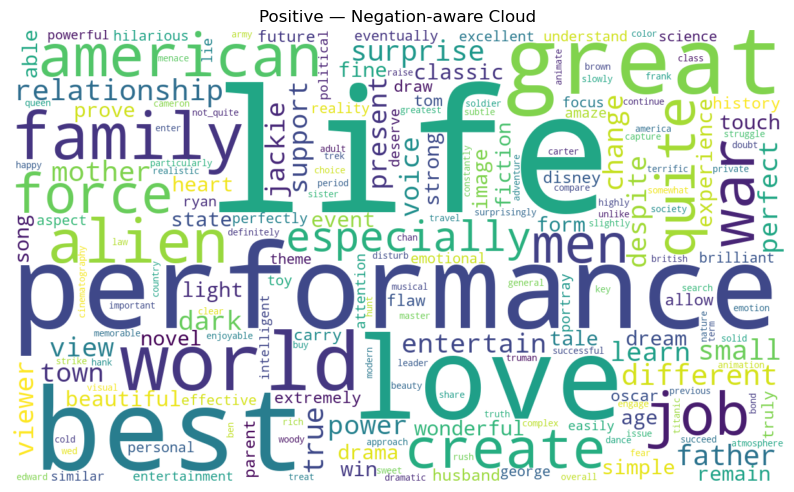

In [91]:
# --- [7.5: Negation-aware bars + word clouds] ---
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pathlib import Path

# Fallbacks if not already defined above
RANDOM_STATE = globals().get("RANDOM_STATE", 42)
FIG_DIR = Path(FIG_DIR) if "FIG_DIR" in globals() else Path("figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def collect_tokens_by_label(df, label_value):
    """
    Use the MODEL tokenizer (adds *_NEG) so visuals become negation-aware.
    Assumes tokenize_for_model(...) was defined in Section 7.2.
    """
    bag = []
    for txt in df[df["label"] == label_value]["text"]:
        bag.extend(tokenize_for_model(txt))
    return Counter(bag)

# 1) Build modeling bags (contain *_NEG tokens)
neg_model_cnt = collect_tokens_by_label(df, "neg")
pos_model_cnt = collect_tokens_by_label(df, "pos")

def collapse_neg(counter: Counter) -> Counter:
    """
    Turn tokens like 'good_NEG' -> 'not good' for human-readable charts.
    Drop bare negators ('not','no','never') so they don't dominate.
    """
    out = Counter()
    for tok, c in counter.items():
        if tok.endswith("_NEG"):
            out["not " + tok[:-4]] += c
        elif tok not in {"not", "no", "never"}:
            out[tok] += c
    return out

neg_negaware = collapse_neg(neg_model_cnt)
pos_negaware = collapse_neg(pos_model_cnt)

# 2) (Optional) keep only tokens distinctive to each class for clearer visuals
def distinctive(base: Counter, other: Counter, min_total=80, ratio=1.5) -> Counter:
    """
    Keep tokens frequent in 'base' and >= 'ratio' times as frequent as in 'other'.
    """
    filt = Counter()
    for w, a in base.items():
        b = other.get(w, 0)
        if a + b >= min_total and (a + 1) / (b + 1) >= ratio:
            filt[w] = a
    return filt

neg_for_plot = distinctive(neg_negaware, pos_negaware) or neg_negaware
pos_for_plot = distinctive(pos_negaware, neg_negaware) or pos_negaware

# 3) Negation-aware BAR GRAPHS (reuses your 7.3 plot_top_n)
plot_top_n(neg_for_plot, "Top 15 — Negative (Negation-aware)", 15)
plot_top_n(pos_for_plot, "Top 15 — Positive (Negation-aware)", 15)

# 4) Negation-aware WORD CLOUDS
def save_wc_phrases(counter: Counter, title: str, out_path: Path):
    """
    WordCloud splits on spaces, so render phrases as single tokens by replacing
    the space in 'not good' -> 'not_good' (purely visual).
    """
    freqs = {k.replace(" ", "_"): v for k, v in counter.items()}
    wc = WordCloud(
        width=1200, height=700, background_color="white",
        stopwords=set(),            # don't drop 'not_good' etc.
        collocations=False,
        random_state=RANDOM_STATE
    ).generate_from_frequencies(freqs)
    wc.to_file(str(out_path))
    print(f"Saved: {out_path}")
    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off"); plt.title(title)
    plt.show()

WORDCLOUD_NEG_NEGAWARE = FIG_DIR / "wordcloud_negative_negationaware.png"
WORDCLOUD_POS_NEGAWARE = FIG_DIR / "wordcloud_positive_negationaware.png"

save_wc_phrases(neg_for_plot, "Negative — Negation-aware Cloud", WORDCLOUD_NEG_NEGAWARE)
save_wc_phrases(pos_for_plot, "Positive — Negation-aware Cloud", WORDCLOUD_POS_NEGAWARE)

In [8]:
import os, re, json, joblib, numpy as np, pandas as pd
from pathlib import Path
from typing import List
from scipy.sparse import csr_matrix, hstack, save_npz
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from datetime import datetime

# ---------- Config ----------
BASE_REVIEW_DIR = r"G:\MSc in Business Analystics\First Year\Semester 3\CMM724 - Web Mining\Coursework\Film Review\Review"
ENGLISH_CSV     = str(Path(BASE_REVIEW_DIR).parent / "processed" / "reviews_english_only.csv")
OUT_DIR         = Path(BASE_REVIEW_DIR).parent / "processed" / "q34_dtms"
OUT_DIR.mkdir(parents=True, exist_ok=True)
RANDOM_STATE    = 42
TEST_SIZE       = 0.20

# Custom stopwords (domain-light; tweak if you want)
CUSTOM_STOP = {
    "film","films","movie","movies","scene","scenes",
    "character","characters","story","plot","director"
}
CUSTOM_STOP = set(CUSTOM_STOP) | set(ENGLISH_STOP_WORDS)
STOP_LIST = sorted(list(CUSTOM_STOP))  # <-- ensure list (not set) for scikit-learn

# ---------- Helpers ----------
def read_text_safe(fp: Path) -> str:
    for enc in ("utf-8","latin-1"):
        try:
            return fp.read_text(encoding=enc, errors="ignore")
        except Exception:
            continue
    return ""

def load_reviews() -> pd.DataFrame:
    en_csv = Path(ENGLISH_CSV)
    if en_csv.exists():
        df = pd.read_csv(en_csv)
        cols = [c for c in ["doc_id","label","text"] if c in df.columns]
        df = df[cols].rename(columns={"text":"text"}).fillna({"text":""})
        if "doc_id" not in df.columns:
            df.insert(0, "doc_id", np.arange(len(df)))
        return df
    # fallback: read raw folders
    base = Path(BASE_REVIEW_DIR)
    rows = []
    for label in ("neg","pos"):
        for fp in (base/label).glob("*.txt"):
            rows.append({"doc_id": fp.stem, "label": label, "text": read_text_safe(fp)})
    return pd.DataFrame(rows)

TOKEN_RE = re.compile(r"\b[a-zA-Z][a-zA-Z'-]{1,}\b")
def regex_tokenize(text: str) -> List[str]:
    return TOKEN_RE.findall(str(text).lower())

# Optional lemmatizer/stemmer
try:
    import nltk
    from nltk.stem import WordNetLemmatizer, SnowballStemmer
    nltk.download("wordnet", quiet=True); nltk.download("omw-1.4", quiet=True)
    _lemmatizer = WordNetLemmatizer()
    _stemmer    = SnowballStemmer("english")
    def lemma_tokenizer(text: str) -> List[str]:
        return [_lemmatizer.lemmatize(t) for t in regex_tokenize(text)]
    def stem_tokenizer(text: str) -> List[str]:
        return [_stemmer.stem(t) for t in regex_tokenize(text)]
except Exception:
    def lemma_tokenizer(text: str) -> List[str]:
        return regex_tokenize(text)
    def stem_tokenizer(text: str) -> List[str]:
        return regex_tokenize(text)

def doc_lengths(texts: List[str]) -> csr_matrix:
    lengths = np.array([len(regex_tokenize(t)) for t in texts], dtype=np.float32).reshape(-1,1)
    return csr_matrix(np.log1p(lengths))  # log-scale

def density(X: csr_matrix) -> float:
    return float(X.count_nonzero()) / (X.shape[0] * X.shape[1]) if X.shape[1] else 0.0

def make_json_safe(obj):
    """Convert sklearn params (callables, sets, numpy types) into JSON-safe forms."""
    import numpy as _np
    if obj is None or isinstance(obj, (str, int, float, bool)):
        return obj
    if isinstance(obj, (list, tuple)):
        return [make_json_safe(x) for x in obj]
    if isinstance(obj, set):
        return sorted(make_json_safe(x) for x in obj)
    if isinstance(obj, dict):
        return {str(k): make_json_safe(v) for k, v in obj.items()}
    if hasattr(obj, "__name__"):
        return obj.__name__
    if isinstance(obj, (_np.generic,)):
        return obj.item()
    if isinstance(obj, (_np.dtype,)):
        return str(obj)
    return str(obj)

# ---------- Load & Split ----------
df = load_reviews()
assert not df.empty, "No reviews found. Check your paths."
y = (df["label"] == "pos").astype(int).values
X_text = df["text"].astype(str).tolist()

X_tr_text, X_te_text, y_tr, y_te, idx_tr, idx_te = train_test_split(
    X_text, y, np.arange(len(df)), test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print(f"Loaded {len(df)} reviews. Split: train={len(X_tr_text)}, test={len(X_te_text)}.")

# ---------- Save blocks ----------
summary = []

def save_block(name: str, vec, Xtr: csr_matrix, Xte: csr_matrix, extra_note: str = "",
               extra_tr: csr_matrix = None, extra_te: csr_matrix = None):
    sub = OUT_DIR / name
    sub.mkdir(parents=True, exist_ok=True)

    if extra_tr is not None:
        Xtr = hstack([Xtr, extra_tr]).tocsr()
        Xte = hstack([Xte, extra_te]).tocsr()

    save_npz(sub / "X_train.npz", Xtr)
    save_npz(sub / "X_test.npz",  Xte)
    joblib.dump(vec, sub / "vectorizer.joblib")

    params = getattr(vec, "get_params", lambda *a, **k: {})()
    info = {
        "variant": name,
        "train_shape": list(Xtr.shape),
        "test_shape": list(Xte.shape),
        "density_train": round(density(Xtr), 6),
        "density_test":  round(density(Xte), 6),
        "vectorizer": type(vec).__name__,
        "params": make_json_safe(params),
        "notes": extra_note
    }
    (sub / "meta.json").write_text(json.dumps(info, indent=2))
    summary.append({
        "Variant": name,
        "Vectorizer": type(vec).__name__,
        "Train shape": f"{Xtr.shape[0]}×{Xtr.shape[1]}",
        "Test shape":  f"{Xte.shape[0]}×{Xte.shape[1]}",
        "Density (train)": round(density(Xtr), 6),
        "Density (test)":  round(density(Xte), 6),
        "Notes": extra_note
    })
    print(f"[{name}] saved → {sub}")

# ---------- V1: Count (uni) ----------
v1 = CountVectorizer(stop_words="english", ngram_range=(1,1))
X1_tr = v1.fit_transform(X_tr_text); X1_te = v1.transform(X_te_text)
save_block("V1_count_uni_enstop", v1, X1_tr, X1_te, extra_note="Count, unigrams, built-in English stopwords")

# ---------- V2: TF-IDF (uni+bi) ----------
v2 = TfidfVectorizer(stop_words="english", ngram_range=(1,2), norm="l2", sublinear_tf=True)
X2_tr = v2.fit_transform(X_tr_text); X2_te = v2.transform(X_te_text)
save_block("V2_tfidf_uni_bi_enstop", v2, X2_tr, X2_te, extra_note="TF-IDF, uni+bi, English stopwords, L2, sublinear TF")

# ---------- V3: TF-IDF (uni) + Lemmatizer + custom stopwords (as LIST) ----------
v3 = TfidfVectorizer(tokenizer=lemma_tokenizer, token_pattern=None, stop_words=STOP_LIST,
                     ngram_range=(1,1), norm="l2")
X3_tr = v3.fit_transform(X_tr_text); X3_te = v3.transform(X_te_text)
save_block("V3_tfidf_uni_lemma_customstop", v3, X3_tr, X3_te,
           extra_note="TF-IDF, unigram, lemmatizer tokenizer, custom domain stopwords (list)")

# ---------- V4: Binary Count (uni) + Stemmer + log(doc length) ----------
v4 = CountVectorizer(tokenizer=stem_tokenizer, token_pattern=None, stop_words="english",
                     ngram_range=(1,1), binary=True)
X4_tr = v4.fit_transform(X_tr_text); X4_te = v4.transform(X_te_text)
len_tr = doc_lengths(X_tr_text);  len_te = doc_lengths(X_te_text)
save_block("V4_binary_uni_stem_len", v4, X4_tr, X4_te,
           extra_note="Binary TF, unigram, stemmer + appended log(doc length)",
           extra_tr=len_tr, extra_te=len_te)

# ---------- V5: TF-IDF (uni) + chi² top-k per class ----------
K_PER_CLASS = 2000
v5_base = TfidfVectorizer(stop_words="english", ngram_range=(1,1), norm="l2")
X5_tr_full = v5_base.fit_transform(X_tr_text)
X5_te_full = v5_base.transform(X_te_text)

scores_pos, _ = chi2(X5_tr_full, y_tr)                   # pos vs rest
idx_top_pos = np.argsort(scores_pos)[::-1][:K_PER_CLASS]
scores_neg, _ = chi2(X5_tr_full, 1 - y_tr)               # neg vs rest
idx_top_neg = np.argsort(scores_neg)[::-1][:K_PER_CLASS]
sel_idx = np.unique(np.concatenate([idx_top_pos, idx_top_neg]))

def subset_csr(X, cols): return X[:, cols]
X5_tr = subset_csr(X5_tr_full, sel_idx)
X5_te = subset_csr(X5_te_full, sel_idx)

class VectorizerWithSelection:
    def __init__(self, base_vec, selected_idx):
        self.base_vec = base_vec
        self.selected_idx = np.array(selected_idx)
    def transform(self, texts):
        return self.base_vec.transform(texts)[:, self.selected_idx]
    def get_params(self, deep=False):
        p = self.base_vec.get_params(deep=deep)
        p["selected_features"] = int(self.selected_idx.size)
        return p

v5 = VectorizerWithSelection(v5_base, sel_idx)
save_block("V5_tfidf_uni_chi2_topk_per_class", v5, X5_tr, X5_te,
           extra_note=f"TF-IDF unigram + chi² top-{K_PER_CLASS} per class (union={len(sel_idx)})")

# ---------- Summary ----------
summary_df = pd.DataFrame(summary)
summary_path = OUT_DIR / f"q34_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
summary_df.to_csv(summary_path, index=False)
print("\n=== Q3.4 Summary ===")
try:
    display(summary_df)
except:
    print(summary_df.to_string(index=False))
print(f"\nSaved summary to: {summary_path}")


Loaded 2000 reviews. Split: train=1600, test=400.
[V1_count_uni_enstop] saved → G:\MSc in Business Analystics\First Year\Semester 3\CMM724 - Web Mining\Coursework\Film Review\processed\q34_dtms\V1_count_uni_enstop
[V2_tfidf_uni_bi_enstop] saved → G:\MSc in Business Analystics\First Year\Semester 3\CMM724 - Web Mining\Coursework\Film Review\processed\q34_dtms\V2_tfidf_uni_bi_enstop


C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


[V3_tfidf_uni_lemma_customstop] saved → G:\MSc in Business Analystics\First Year\Semester 3\CMM724 - Web Mining\Coursework\Film Review\processed\q34_dtms\V3_tfidf_uni_lemma_customstop


C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


[V4_binary_uni_stem_len] saved → G:\MSc in Business Analystics\First Year\Semester 3\CMM724 - Web Mining\Coursework\Film Review\processed\q34_dtms\V4_binary_uni_stem_len
[V5_tfidf_uni_chi2_topk_per_class] saved → G:\MSc in Business Analystics\First Year\Semester 3\CMM724 - Web Mining\Coursework\Film Review\processed\q34_dtms\V5_tfidf_uni_chi2_topk_per_class

=== Q3.4 Summary ===


,Variant,Vectorizer,Train shape,Test shape,Density (train),Density (test),Notes
0,V1_count_uni_enstop,CountVectorizer,1600×36047,400×36047,0.006801,0.006497,"Count, unigrams, built-in English stopwords"
1,V2_tfidf_uni_bi_enstop,TfidfVectorizer,1600×440118,400×440118,0.001260,0.000711,"TF-IDF, uni+bi, English stopwords, L2, subline..."
2,V3_tfidf_uni_lemma_customstop,TfidfVectorizer,1600×38656,400×38656,0.006105,0.005751,"TF-IDF, unigram, lemmatizer tokenizer, custom ..."
3,V4_binary_uni_stem_len,CountVectorizer,1600×27757,400×27757,0.008467,0.008090,"Binary TF, unigram, stemmer + appended log(doc..."
4,V5_tfidf_uni_chi2_topk_per_class,VectorizerWithSelection,1600×2000,400×2000,0.018652,0.018046,TF-IDF unigram + chi² top-2000 per class (unio...



Saved summary to: G:\MSc in Business Analystics\First Year\Semester 3\CMM724 - Web Mining\Coursework\Film Review\processed\q34_dtms\q34_summary_20250816_041439.csv
